# What is the most optimal skill to learn as a Data Scientist?

## Methodology

1. Group skills to determine median salary and likelihood of being in a job posting
2. Visualize median salary vs percent of demand for skills
3. Determine if certain technologies are more prevalent

In [34]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install adjustText
from adjustText import adjust_text

from matplotlib.ticker import PercentFormatter

In [52]:
#Load csv
df = pd.read_csv('../data/data_jobs.csv')

#Data cleaining
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(
    lambda skills: ast.literal_eval(skills)
    if pd.notnull(skills) else skills)

In [53]:
#Filter for Data Scientist jobs in the US
df_DS_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Scientist')].copy()

In [54]:
#Expand (explode) the job_skills column
df_DS_US = df_DS_US.dropna(subset='salary_year_avg')
df_DS_US_explode = df_DS_US.explode('job_skills')

df_DS_US_explode[['salary_year_avg', 'job_skills']].head()

,salary_year_avg,job_skills
100,228222.0,sql
100,228222.0,r
100,228222.0,python
100,228222.0,express
116,114000.0,r


In [55]:
#Create pivot table with median salary and count of skills
df_DS_skills = df_DS_US_explode.groupby(by='job_skills').agg(
    skill_count=('job_skills', 'count'),
    median_salary=('salary_year_avg', 'median')
).sort_values(by='skill_count', ascending=False)

#Total # of DS jobs in the US
DS_job_count = len(df_DS_US)

#Add skill percent column to our pivot table
df_DS_skills['skill_percent'] = round((100*(df_DS_skills['skill_count'] / DS_job_count)), 2)

#Get most in-demand skills
skill_percent_threshold = 10
df_DS_skills_high_demand = df_DS_skills[df_DS_skills['skill_percent'] > skill_percent_threshold]
df_DS_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
python,3358,131867.0,73.75
sql,2463,134500.0,54.10
r,2053,126000.0,45.09
sas,1022,120000.0,22.45
tableau,989,125000.0,21.72
aws,768,134000.0,16.87
spark,718,135959.5,15.77
excel,490,124290.0,10.76
tensorflow,474,149646.0,10.41


In [56]:
df_technology = df['job_type_skills'].copy()

#Remove duplicates
df_technology = df_technology.drop_duplicates()

#Remove NaN values
df_technology = df_technology.dropna()

#Combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) #convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value
            
#Remove duplicates by converting values to set them back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [57]:
#Get technology types for all skills
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,powerpoint
0,analyst_tools,dax
0,analyst_tools,microstrategy
0,analyst_tools,spss
0,analyst_tools,visio
...,...,...
9,sync,wire
9,sync,symphony
9,sync,twilio
9,sync,ringcentral


In [58]:
#Merge DataFrames together to get one single DataFrame with median salary, skill demand (in percent), skills, and technology
df_plot = df_DS_skills_high_demand.merge(df_technology, left_on ='job_skills', right_on='skills')
df_plot.head()

,skill_count,median_salary,skill_percent,technology,skills
0,3358,131867.0,73.75,programming,python
1,2463,134500.0,54.10,programming,sql
2,2053,126000.0,45.09,programming,r
3,1022,120000.0,22.45,analyst_tools,sas
4,1022,120000.0,22.45,programming,sas


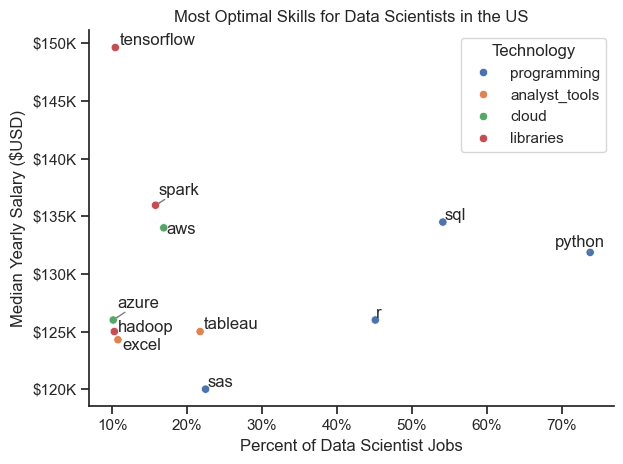

In [63]:
#Visualize plot
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

#Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DS_skills_high_demand.index):
    texts.append(plt.text(df_DS_skills_high_demand['skill_percent'].iloc[i], 
                          df_DS_skills_high_demand['median_salary'].iloc[i],
                          txt))
    
#Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

#Label plot
plt.title('Most Optimal Skills for Data Scientists in the US')
plt.xlabel('Percent of Data Scientist Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.legend(title='Technology')

sns.despine()
sns.set_theme(style='ticks')

ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()